# Checking dataloader output

In [51]:
import os,sys,pathlib
import torch

In [52]:
# Get configs
from config.config import get_cfg_defaults, combine_cfgs

config_path = 'config/Exps/DTxMSCL_DSAD.yaml'
config = combine_cfgs(config_path)

In [53]:
id2label = {
        1: "abdominal_wall",
        2: "colon",
        3: "inferior_mesenteric_artery",
        4: "intestinal_veins",
        5: "liver",
        6: "pancreas",
        7: "small_intestine",
        8: "spleen",
        9: "stomach",
        10: "ureter",
        11: "vesicular_glands"
    }

Single sample visualisation

c:\Users\jayan\anaconda3\envs\DTx\lib\site-packages\transformers\models\detr\image_processing_detr.py:776: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


loading annotations into memory...
Done (t=1.22s)
creating index...
index created!
Number of samples for val from C:\Users\jayan\Documents\MECHATRONICS YR4\MECH5845M - Professional Project\DSAD4DeTr\val\annotations\val_annotations.json: 1978
Batch size for val: 4
Normalisation is  True
idx: 0 image ID: tensor([1010300])
Labels
 Img ID: tensor([1010300]) Size tensor([320, 458]) Classes: tensor([1]) Boxes: tensor([[0.5012, 0.2198, 0.9852, 0.4396]])
 Format of the boxes (center x,center y,w,h). Normilised values.


c:\Users\jayan\anaconda3\envs\DTx\lib\site-packages\transformers\models\detr\image_processing_detr.py:882: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


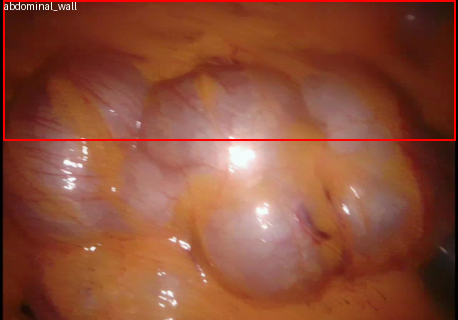

In [63]:
from Visualise import see_sample
from data.DSAD_Wrapper import CocoDSAD
from data.DataTools import get_data
from PIL import Image

dataset, dataloader = get_data(config, 'val')
img = see_sample(0, dataset, id2label, config)
display(img)

see_sample function works as intended.

Now trying with a batch:

In [55]:
# Set up dataloader
if config.DATA.name == 'DSAD':
    from data.DataTools import get_data
    # train_dataset, train_dataloader =  get_data(config, data_tag='train', shuffle=True)
    val_dataset  , val_dataloader   =  get_data(config, data_tag='val')
else:
    print("DSAD Dataset not selected")

loading annotations into memory...
Done (t=1.39s)
creating index...
index created!
Number of samples for val from C:\Users\jayan\Documents\MECHATRONICS YR4\MECH5845M - Professional Project\DSAD4DeTr\val\annotations\val_annotations.json: 1978
Batch size for val: 4


c:\Users\jayan\Documents\MECHATRONICS YR4\MECH5845M - Professional Project\Model\DTx_SurgToolDetector_Dev\Results\visualiseNotebookResults\batch0.jpg
dict_keys(['pixel_values', 'pixel_mask', 'labels'])


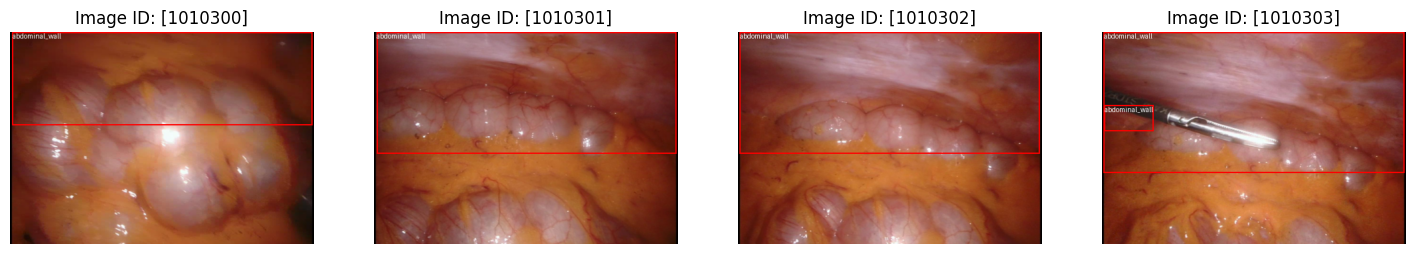

In [56]:
from pathlib import Path
from Visualise import see_batch

save_path = Path().cwd() / 'Results' / 'visualiseNotebookResults' / 'batch0.jpg'
print(save_path)

for batch in val_dataloader:
    pprint(batch.keys())
    see_batch(batch, id2label, config, save_path)
    break


see_batch function works as intended. Neither of these functions use the format_data function. Suggests there is an issue with the output of the model being sorted via the format_data function.

Now checking with output of model:

In [57]:
# Load facebook or DSAD trained model
import os
import torch
from modeling.ModelTools import get_model
from tools import DETR_Wrapp
from transformers import DetrForObjectDetection

# # Uncomment for pretrained facebook model
# model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

# Uncomment for trained model on HPC
detector = get_model(config)
model = DETR_Wrapp(detector, config)
model_path = os.path.join('Models', 'job6665968.pt')
# model_path = os.path.join('Models', 'initial_test.pt')
model.model.load_state_dict(torch.load(model_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([12]) in the model instantiated
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([12, 256]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Changing backbone config.
Adding Res2Net multiscale blocks
Using Res2Net res2net50_26w_4s
Adding connections for dense inference.
Used feature maps are [2, 3]


In [58]:
# Define see_output here for debugging of the actual function in Visualise.py
from Visualise import format_data, draw_boxes
import matplotlib.pyplot as plt
from pprint import pprint

def see_output(output, batch, id2label, config, save_path):
    """ Visualise the output of the model
    Args:
        output (dict): Output of the model
        batch (dict): Batch of samples to visualise
        id2label (dict): Dictionary mapping class indices to class names
        config (dict): Config dictionary
    """
    GT_COLOR = (10,70,0)
    P_COLOR = (20,0,255)
    pixel_values = batch["pixel_values"]
    labels = batch["labels"]
    batch_size = len(labels)
    pprint(labels[0])
    pprint("")
    pprint(output[0])


    if int(batch_size/4)<1:
        rows,cols = 1,batch_size
    else:
        rows,cols = int((3+batch_size)/4) , 4
    
    fig, axes = plt.subplots(rows,cols,figsize=(25,13))
    for item,ax in enumerate(fig.axes):
        ax.set_axis_off()
        if item<batch_size:
            img = pixel_values[item,:,:,:]
            labels[item].update(output[item])
            img, boxes = format_data(img,labels[item],config)

            if 'image_id' in labels[item].keys():
                img_id = labels[item]['image_id'].numpy()[0]
                ax.set_title(f"Image ID: {img_id}")
            
            if 'boxes' in boxes.keys():
                gt_boxes = boxes['boxes']
                tags = [f"{id2label[idx]}"  for idx in labels[item]['class_labels'].numpy()]
                draw_boxes(img, gt_boxes, tags, True, GT_COLOR)

            if 'p_boxes' in boxes.keys():
                pred_boxes = boxes['p_boxes']
                tags = [f"{id2label[idx]} {100*score:3.2f}%"  for idx,score 
                        in zip(labels[item]['p_class'].numpy(),labels[item]['p_score'].numpy())]
                draw_boxes(img, pred_boxes, tags, False, P_COLOR)

            ax.imshow(img)

            img.save(save_path)

c:\Users\jayan\Documents\MECHATRONICS YR4\MECH5845M - Professional Project\Model\DTx_SurgToolDetector_Dev\Results\visualiseNotebookResults\outputBatch0.jpg


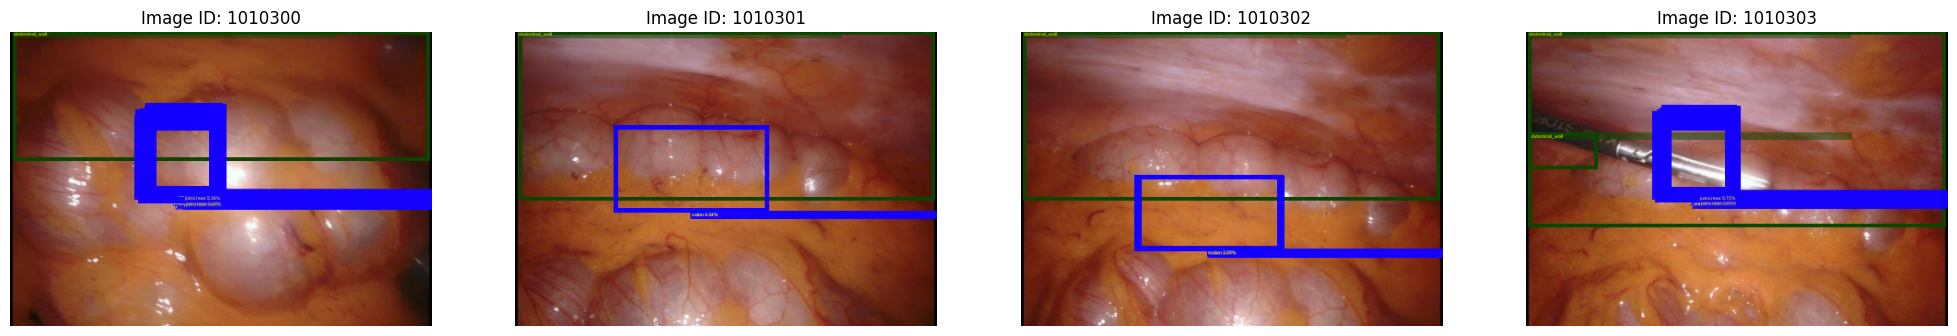

In [59]:
# Obtain and save the outputs of the model
import torch
from pprint import pprint
from Visualise import see_output
from tools import process_output

save_path = Path().cwd() / 'Results' / 'visualiseNotebookResults' / 'outputBatch0.jpg'
print(save_path)

for batch in val_dataloader:
    #pprint(batch)
    pixel_values = batch['pixel_values'].to(device)
    pixel_mask = batch['pixel_mask'].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch['labels']]

    # forward pass
    with torch.no_grad():
      output = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    processed_output = process_output(output, threshold=0.03)

    see_output(processed_output, batch, id2label, config, save_path)
    
    break

#################################################






Old attempt at visualisation. Not needed for now.

tensor([1010300])


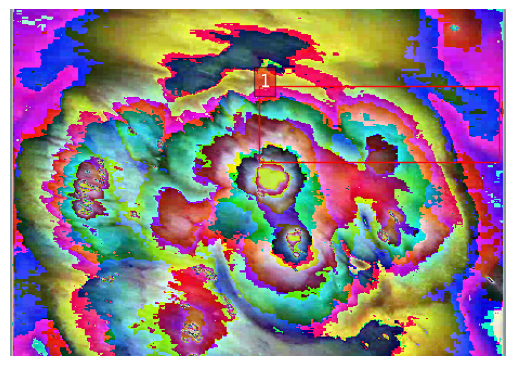

tensor([1010301])


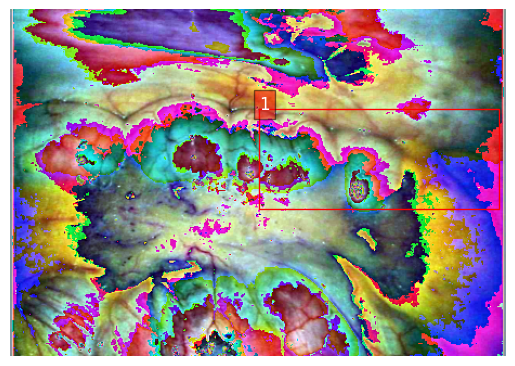

tensor([1010302])


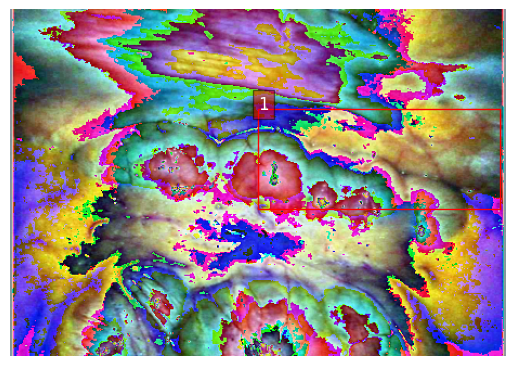

tensor([1010303])


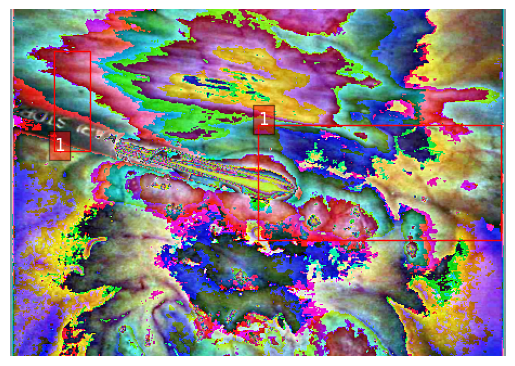

In [60]:
# Optional: Display the images using a plotting library like matplotlib
# Only needed if you want to visualize the data
import matplotlib.pyplot as plt
from pprint import pprint
import Visualise
import numpy as np
from PIL import Image

# Function to display images and annotations
def plot_image_with_annotations(image, annotation):
    plt.imshow(image)
    
    boxes = annotation['boxes'].cpu().numpy()
    labels = annotation['class_labels'].cpu().numpy()
    
    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        xmin *= image.width
        xmax *= image.width
        ymin *= image.height
        ymax *= image.height
        
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='red')
        plt.gca().add_patch(rect)
        plt.text(xmin, ymin, str(label), color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))
    
    plt.axis('off')  # Hide the axis
    plt.show()

for batch in val_dataloader:
    # Extract pixel values, mask and labels
    pixel_values = batch['pixel_values']
    pixel_masks = batch['pixel_mask']
    labels = batch['labels']

    for i in range(pixel_values.size(0)):
        image_tensor = pixel_values[i]
        annotation = labels[i]
        print(annotation['image_id'])
        
        # Convert the tensor to a PIL image (unnormalizing if necessary)
        image_array = image_tensor.permute(1, 2, 0).cpu().numpy()
        image_array = (image_array * 255).astype(np.uint8)  # Convert to uint8 if needed
        image = Image.fromarray(image_array)
        
        # Visualize the image with annotations
        plot_image_with_annotations(image, annotation)
    
    # Break after one batch for demonstration purposes (optional)
    break